# Drift correction

...for GPS tracks collected on drifting sea ice.

### needed:
- a mobile GPS track with X and Y (long, lat) coordinate pairs which needs drift removed
- a reference GPS track which contains the drift to be removed (eg from a fixed-to-floe GPS)

### basic strategy:
1. collect a common time window between the reference and mobile GPS track
2. choose a projected coordinate system expressed in meters, and reproject both GPS tracks to it
3. if one track has a higher time resolution, interpolate the other track so that both tracks have the same time resolution
4. subtract the reference track positions from the mobile track positions

### caveat:

This strategy assumes the ice floe has not rotated significantly during the survey.

In [1]:
## import all the libraries

# standard stuff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta

# reprojection help
import pyproj
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

# xml help for GPX files
import xml.etree.ElementTree as et

# cartopy, basemap is deprecated

In [2]:
## functions we make ourselves go here

## these are from PhD work in 2015
def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-5.
    end = np.max(t2)+5.
    idx = (t1>start)*(t1<end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

# sometimes we can get lucky and get proj to find a UTM code for us
def getutm(lon,lat):
    utm_crs_list = query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(
            west_lon_degree=lon-0.1,
            south_lat_degree=lat-0.1,
            east_lon_degree=lon+0.1,
            north_lat_degree=lat+0.1,
            ),
        )
    print(utm_crs_list)
    return utm_crs_list[0].code

# convert from lat lon to UTM
def makeutm(lon,lat,utmcode):
    
    thetransform = pyproj.transformer.Transformer.from_proj(4326,utmcode)
    gnssutm=thetransform.transform(lat, lon)
    east = gnssutm[0]
    north = gnssutm[1]
    
    return east, north

def readbasegps(filename):
    if 'gpx' in filename:
        # do xml parsing
        tree = et.parse(filename)
        print(filename)
        root = tree.getroot()
        trk = root.find('{http://www.topografix.com/GPX/1/1}trk')
        trksegs = trk.findall('{http://www.topografix.com/GPX/1/1}trkseg')
        trkpts = []
        for trkseg in trksegs:
            trkpts = trkpts + trkseg.findall('{http://www.topografix.com/GPX/1/1}trkpt')
        lon_pts = [float(trkpt.get('lon')) for trkpt in trkpts]
        lat_pts = [float(trkpt.get('lat')) for trkpt in trkpts]
        thetimes = [datetime.strptime(trkpt.find('{http://www.topografix.com/GPX/1/1}time').text,'%Y-%m-%dT%H:%M:%SZ')  for trkpt in trkpts]
        
        start_time = trkpts[0].find('{http://www.topografix.com/GPX/1/1}time')
        #start_time = datetime.strptime(start_time.text, '%Y-%m-%dT%H:%M:%SZ')
        
        stop_idx = max(np.nonzero(np.diff(lat_pts))[0][-1],np.nonzero(np.diff(lon_pts))[0][-1])
        lon_pts = lon_pts[:stop_idx]
        lat_pts = lat_pts[:stop_idx]
        times = thetimes[:stop_idx]
        
    else:
        # assume POS CVS file, read with Pandas
        gnsstrack = pd.read_csv(filename,
                       skiprows=18)
        
        thetimes = gnsstrack[gnsstrack.keys()[0]].values
        print(thetimes[0:4])
        lat_pts = gnsstrack[" latitude(deg)"].values
        lon_pts = gnsstrack["longitude(deg)"].values
        # remove any leading or trailing spaces from the time string using strip,
        # drop precision to milliseconds (6 decimal places) by removing the last 0
        # then convert it to a datetime object
        times = [datetime.strptime(thistime.strip()[0:-1], "%Y/%m/%d %H:%M:%S.%f") for thistime in thetimes]
    
    #return lists of lon, lat and time, we do reprojection in its own function later
    return lon_pts, lat_pts, times

In [3]:

def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = t2[0]
    end = t2[-1]
    
    print(start)
    
    lowidx = np.where(t1 < start)
    highidx = np.where(t1 > end)
    
    print(lowidx[0][-1])
    print(highidx[0][0])
    
    the_inds = np.arange(lowidx[0][-1], highidx[0][0]+1,1)
    
    
    #idx = (t1>=start)*(t1=<end)
    
    #the_inds = np.where(idx)
    #if t1[the_inds[0]] > start:
    #    inds2 = np.where(t1)
        
        
    return np.asarray(the_inds), start, end

In [5]:
glat, glon,gtimes = readbasegps("/mnt/documents/JC2-2/P8-01092021/gnss/base3-near/kppp/")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/documents/JC2-2/P8-01092021/gnss/base3-near/kppp/03092021-base3-day3.pos'

In [6]:
glat[0:5]

array([24.94433386, 24.94422888, 24.94422837, 24.94422826, 24.94422794])

In [87]:
gtimes[-1]

datetime.datetime(2021, 9, 2, 17, 45, 7)

In [88]:
gnssdayseconds=[]
for thetime in gtimes:
    hour = datetime.strftime(thetime, "%H")
    minute = datetime.strftime(thetime, "%M")
    second = datetime.strftime(thetime, "%S")
    millisecond = float(datetime.strftime(thetime, "%f")) / 1000000
    gnssdayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + int(second) + float(millisecond))

Now we have an ice floe drift track loaded, either from a handheld GPS fixed to the ice (gpx files) or kPPP processed GPS base stations (pos files)

### Transform track data to UTM (or other projected system measured in meters)

In [89]:
## get the UTM zone
utmzone=getutm(glon[0], glat[0])
utmzone

[CRSInfo(auth_name='EPSG', code='32644', name='WGS 84 / UTM zone 44N', type=<PJType.PROJECTED_CRS: 'PROJECTED_CRS'>, deprecated=False, area_of_use=AreaOfUse(west=78.0, south=0.0, east=84.0, north=84.0, name='Between 78°E and 84°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Nepal. Russian Federation. Sri Lanka.'), projection_method_name='Transverse Mercator')]


'32644'

In [90]:
## set up the proj transformer

thetransform = pyproj.transformer.Transformer.from_proj(4326,3413)

In [91]:
gnssutm = thetransform.transform(glat, glon)
gnssutm = np.array(gnssutm)

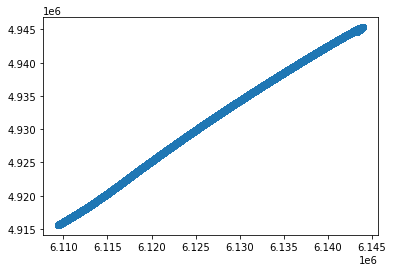

In [92]:
plt.scatter(gnssutm[0], gnssutm[1])

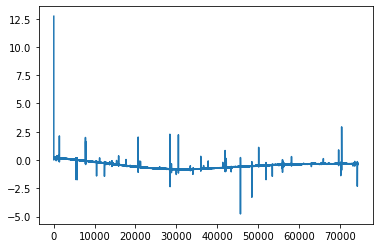

In [93]:
plt.plot(np.diff(gnssutm[0]))

In [94]:
gnssdayseconds[0:5]

[26654.0, 26654.5, 26655.0, 26655.5, 26656.0]

## Load  GEM2 data to be drift corrected

In [95]:
gem2inputfile = "/mnt/documents/JC2-2/P8-01092021/gem2/02092021/JC2-2-P8-transect-02092021-gem2-531-channel-thickness.csv"

In [96]:
gem2data = pd.read_csv(gem2inputfile, low_memory = False)

In [97]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
0     2021-09-01T12:10:21.515625           0         0.0        0.0  0.0  0.0   
1     2021-09-01T12:10:21.617187           1         0.0        0.0  0.0  0.0   
2     2021-09-01T12:10:21.718750           2         0.0        0.0  0.0  0.0   
3     2021-09-01T12:10:21.820312           3         0.0        0.0  0.0  0.0   
4     2021-09-01T12:10:21.921875           4         0.0        0.0  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
7933  2021-09-01T12:23:34.828125        7933         0.0        0.0  0.0  0.0   
7934  2021-09-01T12:23:34.929687        7934         0.0        0.0  0.0  0.0   
7935  2021-09-01T12:23:35.031250        7935         0.0        0.0  0.0  0.0   
7936  2021-09-01T12:23:35.132812        7936         0.0        0.0  0.0  0.0   
7937  2021-09-01T12:23:35.226562        7937         0.0        0.0  0.0  0.0   

       f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
0             2.087          1.945           1.920           1.913   
1             2.236          1.892           1.921           1.919   
2             3.765          1.912           1.922           1.942   
3             2.859          1.992           2.099           1.950   
4             1.762          1.945           2.242           1.945   
...             ...            ...             ...             ...   
7933          0.080          0.684           0.715           0.627   
7934          0.386          0.707           0.708           0.615   
7935          0.558          0.745           0.838           0.614   
7936          0.888          0.739           0.834           0.622   
7937          1.130          0.676           0.727           0.623   

       f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
0              1.981           1.931            1.939            1.916   
1              1.964           1.925            1.933            1.916   
2              1.968           1.918            1.939            1.917   
3              1.970           1.919            1.937            1.916   
4              1.961           1.917            1.938            1.916   
...              ...             ...              ...              ...   
7933           0.635           0.619            0.568            0.650   
7934           0.638           0.614            0.566            0.649   
7935           0.644           0.612            0.566            0.649   
7936           0.646           0.617            0.568            0.648   
7937           0.646           0.623            0.570            0.650   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
0               1.921            1.895  
1               1.923            1.892  
2               1.924            1.893  
3               1.923            1.896  
4               1.925            1.897  
...               ...              ...  
7933            0.549            0.845  
7934            0.549            0.845  
7935            0.550            0.846  
7936            0.550            0.845  
7937            0.550            0.845  

[7938 rows x 16 columns]

In [98]:
gem2data.drop(gem2data[gem2data[" longitude"] == 0].index, inplace=True)
gem2data.drop(gem2data[gem2data[" latitude"] == 0].index, inplace=True)

In [99]:
gem2data

time   record_id   longitude   latitude   xc   yc  \
9     2021-09-01T12:10:22.421875           9   25.065791  83.831564  0.0  0.0   
10    2021-09-01T12:10:22.515625          10   25.065793  83.831564  0.0  0.0   
11    2021-09-01T12:10:22.617187          11   25.065794  83.831564  0.0  0.0   
12    2021-09-01T12:10:22.718750          12   25.065796  83.831564  0.0  0.0   
13    2021-09-01T12:10:22.820312          13   25.065797  83.831564  0.0  0.0   
...                          ...         ...         ...        ...  ...  ...   
7920  2021-09-01T12:23:33.531250        7920   25.077599  83.834177  0.0  0.0   
7921  2021-09-01T12:23:33.632812        7921   25.077600  83.834177  0.0  0.0   
7922  2021-09-01T12:23:33.726562        7922   25.077601  83.834177  0.0  0.0   
7923  2021-09-01T12:23:33.828125        7923   25.077603  83.834177  0.0  0.0   
7924  2021-09-01T12:23:33.929687        7924   25.077604  83.834177  0.0  0.0   

       f450Hz_hcp_i   f450Hz_hcp_q   f1530Hz_hcp_i   f1530Hz_hcp_q  \
9             1.801          1.946           1.867           1.970   
10            2.542          1.868           1.925           1.945   
11            1.479          1.862           1.873           1.955   
12            1.387          1.919           1.756           1.965   
13            1.749          2.004           1.897           1.925   
...             ...            ...             ...             ...   
7920          1.971          0.709           0.758           0.621   
7921          1.912          0.689           0.737           0.626   
7922          1.074          0.707           0.713           0.640   
7923          1.148          0.745           0.711           0.634   
7924          0.592          0.739           0.683           0.624   

       f5310Hz_hcp_i   f5310Hz_hcp_q   f18330Hz_hcp_i   f18330Hz_hcp_q  \
9              1.964           1.940            1.941            1.914   
10             1.960           1.935            1.943            1.915   
11             1.958           1.928            1.937            1.913   
12             1.964           1.917            1.938            1.917   
13             1.934           1.917            1.940            1.919   
...              ...             ...              ...              ...   
7920           0.643           0.618            0.566            0.651   
7921           0.642           0.619            0.564            0.650   
7922           0.632           0.620            0.567            0.648   
7923           0.631           0.618            0.570            0.649   
7924           0.663           0.621            0.569            0.651   

       f63030Hz_hcp_i   f63030Hz_hcp_q  
9               1.926            1.898  
10              1.921            1.900  
11              1.917            1.899  
12              1.922            1.896  
13              1.923            1.898  
...               ...              ...  
7920            0.550            0.847  
7921            0.549            0.847  
7922            0.549            0.846  
7923            0.550            0.846  
7924            0.550            0.845  

[7916 rows x 16 columns]

In [100]:
f1530hz_hcp_i = [float(zi) for zi in gem2data[" f1530Hz_hcp_i"].values]

In [101]:
gem2utm = thetransform.transform(gem2data[" latitude"].values, gem2data[" longitude"].values)

In [102]:
gem2easting = gem2utm[0]
gem2northing = gem2utm[1]

Text(0.5, 1.0, 'uncorrected GEM2track - local coordinates')

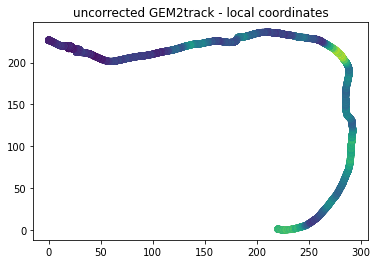

In [104]:
plt.scatter(gem2easting-np.min(gem2easting), gem2northing-min(gem2northing), c = f1530hz_hcp_i)
plt.title("uncorrected GEM2track - local coordinates")

In [105]:
gem2times = gem2data['time'].values
gem2dayseconds=[]
for thetime in gem2times:
    thisdate, thistime = thetime.split('T')
    #print(thistime)
    hour, minute, second = thistime.split(':')
    #print(len(thetime))
    #print(thetime)
    gem2dayseconds.append(((int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(second))

In [106]:
gem2dayseconds = np.round(gem2dayseconds, 4)

In [107]:
gem2times[-2]

'2021-09-01T12:23:33.828125'

In [108]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, gem2dayseconds)

36622.4219
19936
21520


In [109]:
gnss_trimmedtime = np.array(np.squeeze(gnss_trimmedtime))

In [110]:
gnss_trimmedtime

array([19936, 19937, 19938, ..., 21518, 21519, 21520])

In [111]:
start

36622.4219

In [112]:
end

37413.9297

In [113]:
gnssdayseconds = np.array(gnssdayseconds)

In [114]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [115]:
trimmedtime[0]

36622.0

In [116]:
gem2dayseconds[0]

36622.4219

In [117]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.0001)
timesteps = np.round(timesteps, 4)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)
    

In [118]:
timesteps = np.round(timesteps, 4)

In [119]:
timesteps[0]

36621.5

In [120]:
gem2dayseconds[0]

36622.4219

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in gem2dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

In [40]:
len(timeindexes)

3852

In [41]:
len(gem2dayseconds)

3852

In [42]:
gnss_gem2_match_eastings = interp_east[timeindexes]
gnss_gem2_match_northings = interp_north[timeindexes]

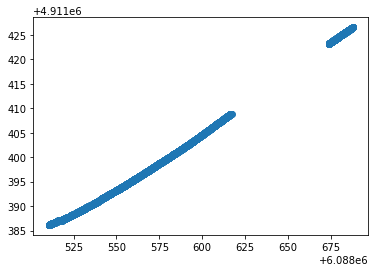

In [43]:
plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

In [44]:
gnss_gem2_match_eastings[0]

array([6088510.40560224])

In [45]:
len(gnss_gem2_match_eastings)

3852

In [46]:
len(gem2easting)

3852

In [47]:
gnss_gem2_match_eastings = np.squeeze(gnss_gem2_match_eastings)
gnss_gem2_match_northings = np.squeeze(gnss_gem2_match_northings)

In [48]:
gnss_gem2_match_eastings[0]

6088510.405602237

In [49]:
gem2easting[0]

624829.6556773902

In [50]:
local_gem2_east = gem2easting - gnss_gem2_match_eastings
local_gem2_north = gem2northing - gnss_gem2_match_northings

In [51]:
local_gem2_east[0]

-5463680.749924847

In [52]:
local_gem2_north[0]

-5134528.406887419

In [53]:
world_gem2_east = local_gem2_east + gnss_gem2_match_eastings[0]
world_gem2_north = local_gem2_north + gnss_gem2_match_northings[0]

In [54]:
world_gem2_east.size

3852

In [55]:
gnss_gem2_match_eastings[0]

6088510.405602237

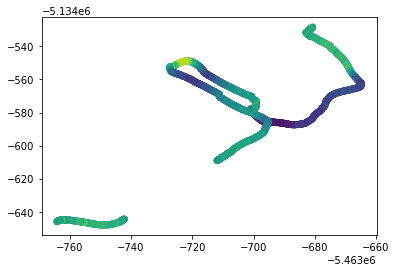

In [56]:
plt.scatter(local_gem2_east, local_gem2_north, c=f1530hz_hcp_i)

In [57]:
gem2_header = """AeN Q2 2021 P6 GEM2 measurements
GEM2-531 electromagnetic induction sounder
9 May 2021\nAdam Steer / Polona Itkin
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coodinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730
-----------------------------------------
"""

In [58]:
gem2_easting_df = pd.DataFrame({"easting": world_gem2_east})

In [59]:
gem2out = gem2data.copy()

In [60]:
gem2data.keys()

Index(['time', ' record_id', ' longitude', ' latitude', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [61]:
gem2out.drop(columns = [" longitude", " latitude"], inplace=True)
gem2out.keys()

Index(['time', ' record_id', ' xc', ' yc', ' f450Hz_hcp_i', ' f450Hz_hcp_q',
       ' f1530Hz_hcp_i', ' f1530Hz_hcp_q', ' f5310Hz_hcp_i', ' f5310Hz_hcp_q',
       ' f18330Hz_hcp_i', ' f18330Hz_hcp_q', ' f63030Hz_hcp_i',
       ' f63030Hz_hcp_q'],
      dtype='object')

In [62]:
gem2out.insert(2, "easting", world_gem2_east)

In [63]:
gem2out.insert(3, "northing", world_gem2_north)

In [64]:
gem2out.keys()

Index(['time', ' record_id', 'easting', 'northing', ' xc', ' yc',
       ' f450Hz_hcp_i', ' f450Hz_hcp_q', ' f1530Hz_hcp_i', ' f1530Hz_hcp_q',
       ' f5310Hz_hcp_i', ' f5310Hz_hcp_q', ' f18330Hz_hcp_i',
       ' f18330Hz_hcp_q', ' f63030Hz_hcp_i', ' f63030Hz_hcp_q'],
      dtype='object')

In [77]:
gem2_output = "/mnt/documents/JC2-2/P8-01092021/gem2/02092021/GEM2data-driftcorrected.csv"

In [78]:
with open(gem2_output, 'w') as outfile:
    outfile.write(gem2_header)
    

In [79]:
gem2out.to_csv(gem2_output, index=False, mode='a')

## Load Magnaprobe data to be drift corrected

Using the Alaska Magnaprobe we need to add 8 hours to timestamps...

In [68]:
magnaprobeinputfile = "/mnt/documents/Q2/AeNP6-09052021/transect/magnaprobe/P43552_P6.dat"


In [69]:
mpcolumns = ["TIMESTAMP","RECORD","Counter","DepthCm","BattVolts","latitude_a","latitude_b","Longitude_a","Longitude_b","fix_quality","nmbr_satellites","HDOP","altitudeB","DepthVolts","LatitudeDDDDD","LongitudeDDDDD","month","dayofmonth","hourofday","minutes","seconds","microseconds"]

In [70]:
mpdata = pd.read_csv(magnaprobeinputfile, skiprows=4, names = mpcolumns)

In [71]:
mpdepths = mpdata["DepthCm"].values / 100
mprawtimes = mpdata["TIMESTAMP"].values

fixedtime = []
for thetime in mprawtimes:
    try:
        fixedtime.append(datetime.strptime(thetime, "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 9))
        
    except ValueError:
        fixedtime.append(datetime.strptime(thetime, "%Y-%m-%d %H:%M:%S") + timedelta(hours = 9))

mprawtimes = [datetime.strftime(thetime, "%Y-%m-%d %H:%M:%S.%f") for thetime in fixedtime]
mprawtimes[0].split(' ')
mprawdays = [thistime.split(' ')[0] for thistime in mprawtimes]
mptimes = [thistime.split(' ')[1] for thistime in mprawtimes]
mpdays = [datetime.strptime(thisday, "%Y-%m-%d") for thisday in mprawdays]
mptimes = np.array(mptimes)

In [72]:
mprawtimes[100]

'2021-05-10 07:08:55.360000'

In [73]:
datetime.strptime(mprawtimes[0], "%Y-%m-%d %H:%M:%S.%f") + timedelta(hours = 8)

datetime.datetime(2021, 5, 10, 15, 1, 10, 190000)

In [74]:
mpdaysfixed = [day + weekdelta for day in mpdays]

NameError: name 'weekdelta' is not defined

In [ ]:
mptimes

In [ ]:
mp_dayseconds=[]
for thetime in mptimes:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    mp_dayseconds.append((int(hour)*3600.0) + (int(minute) * 60.0) + float(second))

In [ ]:
mp_dayseconds = np.round(mp_dayseconds, 2)
mp_dayseconds

In [ ]:
gnssdayseconds

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, mp_dayseconds)

In [ ]:
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
timesteps = np.arange(trimmedtime.min()-0.01, trimmedtime.max()+0.01, 0.01)
timesteps = np.round(timesteps, 2)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in mp_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])

In [ ]:
len(timeindexes)

In [ ]:
len(mp_dayseconds)

In [ ]:
gnss_mp_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_mp_match_northings = np.squeeze(interp_north[timeindexes])

Now get geo-data from the magnaprobe organised

In [ ]:
mplatddd = mpdata["latitude_a"].values + (mpdata["latitude_b"].values / 60)
mplonddd = mpdata["Longitude_a"].values + (mpdata["Longitude_b"].values / 60)

In [ ]:
mputm = thetransform.transform(mplatddd, mplonddd)

In [ ]:
mpeasting = mputm[0]
mpnorthing = mputm[1]

In [ ]:
plt.scatter(mpeasting, mpnorthing, c = mpdata["DepthCm"])

Do the drift correction to local coordinates

In [ ]:
local_mp_east = mpeasting - gnss_mp_match_eastings
local_mp_north = mpnorthing - gnss_mp_match_northings

In [ ]:
len(mpeasting)

In [ ]:
len(gnss_mp_match_eastings)

Convert back to world coordinates

In [ ]:
world_mp_east = local_mp_east + gnss_gem2_match_eastings[0]
world_mp_north = local_mp_north + gnss_gem2_match_northings[0]

In [ ]:
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"])

Export data to CSV

In [ ]:
# first generate correct timestamps! Remembering the raw times are 1024 weeks out
mp_timefixed = []
i = 0
for thistime in mptimes:
    theday = datetime.strftime(mpdays[i],"%d-%m-%Y")
    thetimestamp = theday + "T" + thistime
    mp_timefixed.append(thetimestamp)
    i += 1

In [ ]:
# Assemble a dataframe
mp_export = pd.DataFrame({"timestamp": mp_timefixed, 
                          "easting": world_mp_east, 
                          "northing": world_mp_north, 
                          "snowdepth": mpdata["DepthCm"]/100   })

In [ ]:
mp_output = "/mnt/documents/Q2/AeNP6-09052021/transect/magnaprobe/MPdata-driftcorrected-datefixed.csv"

In [ ]:
mp_header = """AeN Q2 2021 P6 Magnaprobe measurements
Snowhydro Magnaprobe NPI-1
9 May 2021\nAdam Steer / Polona Itkin
Time corrected: adding 9 hours to instrument timestamps to account for time zone settings
Drift corrected: using GNSS data collected at an icefloe-fixed site
Coordinates expressed in NSIDC North Polar Stereographic (EPSG:3413)
Code for date and drift correction: https://gitlab.com/adamsteer/aen/-/blob/main/notebooks/drift%20correction.ipynb
Collected for the Nansen Legacy Project: https://arvenetternansen.com
Research Council of Norway project 276730


"""

In [ ]:
with open(mp_output, 'w') as outfile:
    outfile.write(mp_header)
    

In [ ]:
mp_export.to_csv(mp_output, index=False, mode='a')

## Plot GEM2 and magnaprobe data together

In [ ]:
plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200)
plt.scatter(world_mp_east+12, world_mp_north+5, c = mpdata["DepthCm"]/100)

## Load camera centers to be drift corrected

In [ ]:
cameracentrefile = "/mnt/documents/ANAFI-USA/AeNQ2/AeNQ209052021/mapping-images/cameracentres.csv"

In [ ]:
cameradata = pd.read_csv(cameracentrefile)

In [ ]:
cameradata.drop(cameradata[cameradata["GPSLongitude"] == 0].index, inplace=True)
cameradata.drop(cameradata[cameradata["GPSLatitude"] == 0].index, inplace=True)

In [ ]:
camerautm = thetransform.transform(cameradata["GPSLatitude"].values, cameradata["GPSLongitude"].values)

In [ ]:
cameraeasting = camerautm[0]
cameranorthing = camerautm[1]

In [ ]:
plt.scatter(cameraeasting, cameranorthing)

In [ ]:
cameradata

In [ ]:
cam_utm = thetransform.transform(cameradata["GPSLatitude"], cameradata["GPSLongitude"])

In [ ]:
cam_rawtimes = cameradata["DateTimeOriginal"].values
cam_rawtimes = cam_rawtimes
cam_rawtimes[0].split(' ')
cam_rawdays = [thistime.split(' ')[0] for thistime in cam_rawtimes]
cam_times = [thistime.split(' ')[1] for thistime in cam_rawtimes]
cam_days = [datetime.strptime(thisday, "%Y:%m:%d") for thisday in cam_rawdays]
cam_times = np.array(cam_times)

In [ ]:
subseconds = [x / 10**len(str(x)) for x in cameradata["SubSecTimeOriginal"]]
subseconds[0:5]

In [ ]:
cam_dayseconds=[]
i = 0
for thetime in cam_times:
    hour, minute, second = thetime.split(':')
    #print(len(thetime))
    #print(thetime)
    cam_dayseconds.append((int(int(hour)-2)*3600.0) + (int(minute) * 60.0) + float(subseconds[i]))
    i += 1

In [ ]:
cam_dayseconds[0]

In [ ]:
gnssutm

In [ ]:
gnss_trimmedtime,start,end = trim_timeseries(gnssdayseconds, cam_dayseconds)

In [ ]:
gnssdayseconds = np.array(gnssdayseconds)

In [ ]:
len(cam_dayseconds)

In [ ]:
len(gnss_trimmedtime[0])

In [ ]:
trimmedeast = np.squeeze(gnssutm[0][gnss_trimmedtime])
trimmednorth = np.squeeze(gnssutm[1][gnss_trimmedtime])
trimmedtime = np.squeeze(gnssdayseconds[gnss_trimmedtime])

In [ ]:
len(trimmedeast)

In [ ]:
min(cam_dayseconds)

In [ ]:
max(cam_dayseconds)

In [ ]:
min(gnssdayseconds)

In [ ]:
max(gnssdayseconds)

In [ ]:
timesteps = np.arange(trimmedtime.min()-0.5, trimmedtime.max()+0.5, 0.001)
timesteps = np.round(timesteps, 3)

interp_east = np.interp(timesteps, trimmedtime, trimmedeast)
interp_north = np.interp(timesteps, trimmedtime, trimmednorth)

In [ ]:
%%time
## a dumb way, but fastest yet: looping over the gem2 dayseconds array,
# searching the GNSS interpolated time array
# for a matching time at each step.
i=0
timeindexes = []
for thistime in cam_dayseconds:
    thistimeindex = np.where(timesteps[:] == thistime)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    else:
        print(thistimeindex[0])

In [ ]:
gnss_cam_match_eastings = np.squeeze(interp_east[timeindexes])
gnss_cam_match_northings = np.squeeze(interp_north[timeindexes])

In [ ]:
local_cam_east = cameraeasting - gnss_cam_match_eastings
local_cam_north = cameranorthing - gnss_cam_match_northings

In [ ]:
local_cam_east[0]

In [ ]:
local_cam_north[0]

In [ ]:
gnss_cam_match_northings[0] - gnss_cam_match_northings[-1]

In [ ]:
plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings)
plt.scatter(cameraeasting[-1], cameranorthing[-1])

In [ ]:
cameraeasting[0]

In [ ]:
gem2easting[0]

In [ ]:
cameranorthing[0]

In [ ]:
gem2northing[0]

In [ ]:
local_gem2_east[0]

In [ ]:
local_mp_east[0]

In [ ]:
plt.scatter(local_cam_east, local_cam_north)

In [ ]:
gnss_gem2_match_eastings[0]

In [ ]:
local_gem2_east[0]

In [ ]:
world_cam_east = local_cam_east + gnss_cam_match_eastings[0]
world_cam_north = local_cam_north + gnss_cam_match_northings[0]

In [ ]:
world_cam_east[0]

In [ ]:
world_gem2_east[0]

In [ ]:
fig = plt.figure(figsize=(20,20))

#plt.scatter(gnssutm[0],gnssutm[1], s = 10, label = 'day 1 drift track')
#plt.scatter(gnss_cam_match_eastings, gnss_cam_match_northings, label = "camera match track")
#plt.scatter(gnss_mp_match_eastings, gnss_mp_match_northings)
#plt.scatter(gnss_gem2_match_eastings, gnss_gem2_match_northings)

plt.scatter(world_gem2_east, world_gem2_north, c=f1530hz_hcp_i, cmap = "Blues", s=200, label = "GEM2")
plt.scatter(world_mp_east, world_mp_north, c = mpdata["DepthCm"]/100, label = "Magnaprobe")
plt.scatter(world_cam_east, world_cam_north, c = cameradata["AboveGroundAltitude"], label = "camera centres", cmap="Greens")
plt.legend()
plt.grid()
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig("/mnt/documents/Q2/AeNP6-09052021/driftracks.png")

In [ ]:
backtolatlon = pyproj.transformer.Transformer.from_proj(3413,4326)

In [ ]:
cam_latlon = backtolatlon.transform(world_cam_east, world_cam_north)

In [ ]:
cam_out = cameradata.copy()

In [ ]:
cam_out["GPSLatitude"] = cam_latlon[0]

In [ ]:
cam_out["GPSLongitude"] = cam_latlon[1]

In [ ]:
mp_output_exiftool = "/mnt/documents/ANAFI-USA/AeNQ2/AeNQ209052021/driftcorrected-for-exiftool.csv"

In [ ]:
cam_out.to_csv(mp_output_exiftool, index=False)

In [ ]:
cam_out['GPSLatitude'][0] - cameradata["GPSLatitude"][0]

In [ ]:
cam_out['GPSLatitude'][0]

cam_o

In [ ]:
cam_out_hag = cam_out.copy()

In [ ]:
cam_out_hag["GPSAltitude"] = cam_out_hag["AboveGroundAltitude"]

In [ ]:
cam_out_hag.drop(columns = ["AboveGroundAltitude"], inplace = True)

In [ ]:
cam_output_exiftool_hag = "/mnt/documents/ANAFI-USA/AeNQ2/AeNQ209052021/driftcorrected-for-exiftool-HAG.csv"

In [ ]:
cam_out_hag.to_csv(cam_output_exiftool_hag, index=False)